In [1]:
import pickle as pkl
import numpy as np
from itertools import chain

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_cdf, plot_forecast_pdf

2024-03-19 09:15:30.600788: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 09:15:30.628303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 09:15:30.628325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 09:15:30.629012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 09:15:30.633288: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 09:15:30.633769: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

base_model = load_model(folder + 'trunc_normal/tn_crps_.pkl')
print(base_model)

Using given parameters for Truncated Normal distribution
EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 200)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.3965224]
  b_tn: [ 0.9656694  -0.01666058 -0.146118    0.03517735  0.00451683]
  c_tn: [1.5007248]
  d_tn: [1.0637333]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582



In [19]:
tn = load_model(folder + 'trunc_normal/tn_twcrps_mean13.0_std2.0_epochs600.pkl')
gev = load_model(folder + 'gev/gev_twcrps_mean13.0_std2.0_epochs600.pkl')
mixture = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std2.0_epochs600.pkl')
mixture2 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std4.0_epochs600.pkl')

models = {'tn': tn, 'gev': gev, 'mixture': mixture, 'mixture2': mixture2}

Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution


In [4]:
print(tn)

EMOS Model Information:
Loss function: loss_twCRPS_sample (Samples: 200)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.944319]
  b_tn: [ 0.876411   -1.1523452  -0.12371749 -0.19847825  1.1735921 ]
  c_tn: [3.0947108]
  d_tn: [0.68173754]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11
Chaining function: chain_function_normal_cdf (Mean: 13.0, Std: 2.0)
Optimizer: Adam
Learning rate: 0.009999999776482582



In [5]:
print(gev)

EMOS Model Information:
Loss function: loss_twCRPS_sample (Samples: 200)
Forecast distribution: distr_gev
Parameters:
  a_gev: [1.1875396]
  b_gev: [ 0.8142442  -1.076038   -0.13067977 -0.21312332  1.4696715 ]
  c_gev: [0.7464433]
  d_gev: [ 0.09497447 -0.19204162 -0.02355615  0.0008516  -0.2924711 ]
  e_gev: [-0.26345688]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11
Chaining function: chain_function_normal_cdf (Mean: 13.0, Std: 2.0)
Optimizer: Adam
Learning rate: 0.009999999776482582



In [6]:
print(mixture)

EMOS Model Information:
Loss function: loss_twCRPS_sample (Samples: 200)
Forecast distribution: distr_mixture_linear
Distribution 1: distr_trunc_normal
Distribution 2: distr_gev
Mixture weight a: [-0.16407575]
Mixture weight b: [-0.00195792]
Parameters:
  weight_a: [-0.16407575]
  weight_b: [-0.00195792]
  a_tn: [0.84101903]
  b_tn: [ 0.7578027  -1.2008458  -0.17822152  0.174605    2.2600632 ]
  c_tn: [3.6660397]
  d_tn: [1.1058623]
  a_gev: [1.1311897]
  b_gev: [ 0.89329886 -1.4417113  -0.10512153 -0.3636278   1.3991839 ]
  c_gev: [0.7811148]
  d_gev: [ 0.04277525  0.19401582 -0.03527989  0.12130946 -0.5093837 ]
  e_gev: [-0.09335995]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11
Chaining function: chain_function_normal_cdf (Mean: 13.0, Std: 2.0)
Optimizer: Adam
Learning rate: 0.009999999776482582



In [7]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test, variances_test = get_tensors(tn.neighbourhood_size, tn.feature_names, test_fold, ignore)
X_test = (X_test - tn.feature_mean) / tn.feature_std

print(X_test.shape)

(7780, 5)


In [17]:
weight = mixture.forecast_distribution.get_distribution(X_test, variances_test).weight.numpy()
print(weight.min())

0.4499661


There are 31 values in the PIT diagram


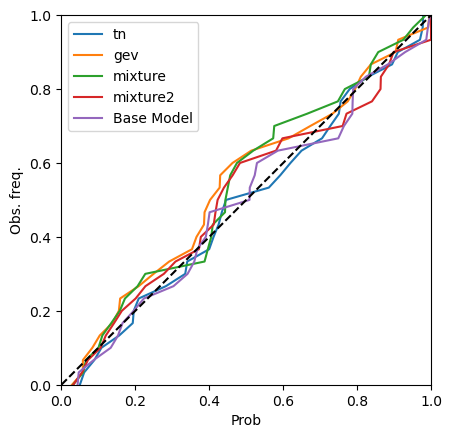

In [24]:
c = 17
make_cpit_diagram_emos(models, X_test, y_test, variances_test, t=c, base_model=base_model)

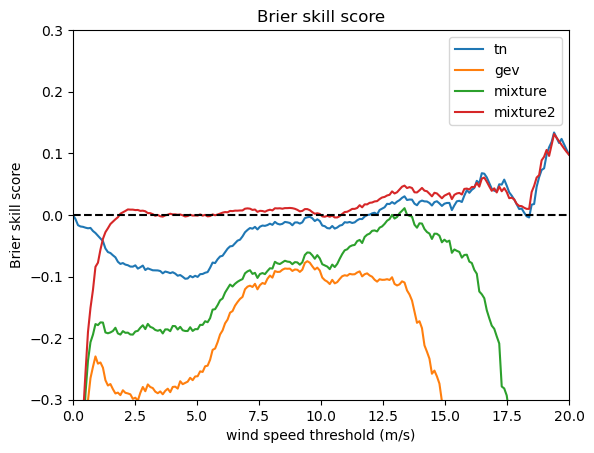

In [21]:
values = np.linspace(0, 20, 200)
ylim = [-0.3, 0.3]
brier_skill_plot(base_model, models, X_test, y_test, variances_test, values, ylim=ylim)

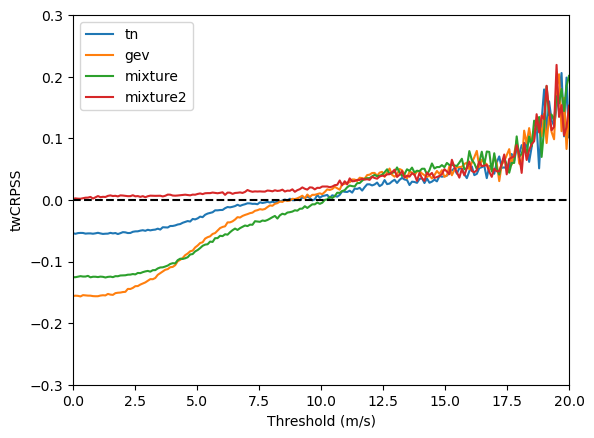

In [22]:
make_twcrpss_plot(base_model, models, X_test, y_test, variances_test, values, ylim=ylim)